# Applications of Image Processing in Machine Learning

In my previous blog posts, we extensively covered the concepts of visualizing, enhancing, and extracting information from images. If you haven't visited my blogs, click [here](https://medium.com/@vjlglopez)! Building upon that knowledge, we are now ready to apply the various algorithms we have discussed in order to create a leaf classification algorithm. Let's put our theoretical understanding into practice. In the blog series, we explored different methods for image analysis, and now we will utilize those techniques to accomplish the following tasks:

1. Reading and cleaning the images
2. Segmenting the objects of interest
3. Extracting informative features from the identified objects
4. Training a machine learning model

Drawing from the insights gained in our previous discussions, it's important to note that the accuracy of our model can be influenced by each step in the pipeline. Prioritizing which step to focus on for improvement will require applying heuristics based on our knowledge and experience. Now, let's embark on this practical exercise to further reinforce our understanding.

In [4]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import joblib
from tqdm.notebook import tqdm, trange

from skimage.io import imread, imshow
from skimage.color import rgb2gray
from skimage.morphology import (erosion, dilation, opening, closing,
                                area_opening, area_closing)
from skimage.filters import threshold_otsu
from skimage.measure import label, regionprops, regionprops_table

from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import (train_test_split, GridSearchCV,
                                     StratifiedKFold)
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.ensemble import (RandomForestClassifier,
                              GradientBoostingClassifier)
from sklearn.metrics import classification_report, accuracy_score

import shap

## Data Preparation

We first visualize our dataset.

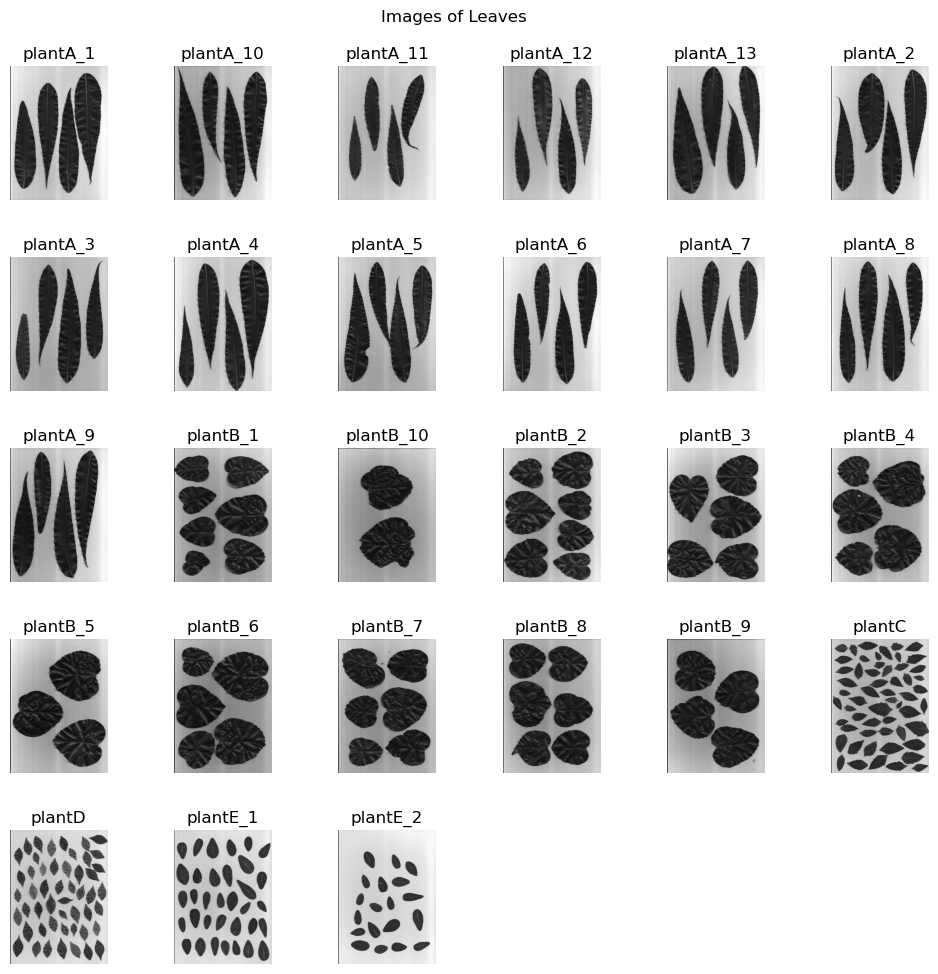

In [5]:
data_folder = 'data'
num_img = len(os.listdir(data_folder))
cols = int(np.ceil(np.sqrt(num_img)))
rows = int(np.ceil(num_img / cols))

fig, axes = plt.subplots(rows, cols, figsize=(10, 10))
fig.suptitle('Images of Leaves', y=1)
fig.tight_layout()
for i in range(cols*rows - num_img):
    fig.delaxes(axes.flat[-(i+1)])

for file, ax in zip(os.listdir(data_folder), axes.flat):
    ax.set_title(file[:-4])
    ax.imshow(rgb2gray(imread(os.path.join(data_folder, file))), cmap='gray')
    ax.axis('off')

#### Image Segmentation and Feature Extraction

The left image, "Binarized Image," presents a grayscale representation of the input image after undergoing binarization, with a focus on the contrast between the object of interest and the background. On the right, the image labeled as "Label 3 of Labeled Image" highlights a specific object of interest within the labeled image, providing a visual emphasis on that particular region.

In [6]:
image_paths = [os.path.join(data_folder, img)
               for img in os.listdir(data_folder)]

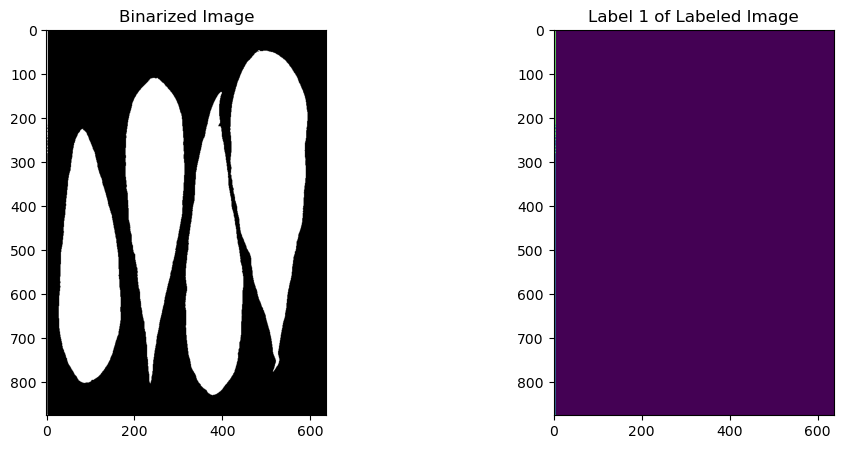

In [7]:
# np.random.choice(image_paths)
image = rgb2gray(imread(image_paths[0]))

thresh = threshold_otsu(image)
bin_img = area_opening(area_closing(image < thresh))
label_img = label(bin_img)
fig, ax = plt.subplots(1, 2, figsize=(12, 5))
ax[0].set_title('Binarized Image')
ax[0].imshow(bin_img, cmap='gray')

ax[1].set_title('Label 1 of Labeled Image')
ax[1].imshow(label_img == 3)

plt.show()

In [12]:
label_sample, area_sample = regionprops(label_img)[3].label, regionprops(label_img)[3].area
print(f'The Label of our chosen section is: {label_sample}')
print(f' The Area of our chosen section is: {area_sample}')

The Label of our chosen section is: 4
 The Area of our chosen section is: 60063.0


#### Dataset Creation

Our goal is to extract meaningful features from a list of images using the regionprops function. The `prop_list` variable specifies the desired properties, including perimeter, inertia tensor, solidity, area_filled, area_convex, axis_major_length, axis_minor_length, eccentricity, bbox, and image. The `process_images` function plays a pivotal role in this process, taking the image list as input and performing tasks such as grayscale conversion, binarization, labeling, and calculation of region properties. The resulting properties are stored in separate DataFrames, filtered based on an area threshold, and then merged into a single DataFrame, `df`, representing the complete dataset. The use of this code enables us to effectively extract informative features from the images, laying a solid foundation for subsequent analysis and modeling endeavors.

In [16]:
prop_list = ['perimeter', 'inertia_tensor', 'solidity', 
             'area_filled', 'area_convex', 'axis_major_length',
             'axis_minor_length', 'eccentricity','bbox', 'image']

def process_images(image_list, prop_list, area_thresh=2000):
    """
    Process each image in the list of images and return a DataFrame with
    features extracted from regionprops.
    """

    df_list = []
    for im_path in image_list:
        image = rgb2gray(imread(im_path))
        bin_image = closing(image < threshold_otsu(image))
        label_image = label(bin_image)

        props_df = pd.DataFrame(
            regionprops_table(label_image, image, prop_list)
        )
        props_df.drop(columns=props_df.columns[props_df.columns
                                               .str.contains('bbox')],
                      inplace=True)
        props_df['class'] = np.repeat(im_path[10], len(props_df))
        df_list.append(props_df[(props_df.area_filled > area_thresh)])
    return pd.concat(df_list).reset_index(drop=True)

df = process_images(image_paths, prop_list)
df.head()

,perimeter,inertia_tensor-0-0,inertia_tensor-0-1,inertia_tensor-1-0,inertia_tensor-1-1,solidity,area_filled,area_convex,axis_major_length,axis_minor_length,eccentricity,image,class
0,1764.077164,0.926873,49.102830,49.102830,66626.044738,0.821632,2879.0,3504.0,1032.481135,3.775043,0.999993,"[[True, True, True, True], [True, True, True, ...",A
1,1647.531096,1771.149825,-606.849230,-606.849230,26124.073603,0.939731,81173.0,86379.0,646.704709,167.620388,0.965826,"[[False, False, False, False, False, False, Fa...",A
2,1525.157467,1019.414043,260.352692,260.352692,23381.300900,0.953704,57763.0,60567.0,611.677454,127.523064,0.978026,"[[False, False, False, False, False, False, Fa...",A
3,1551.820418,963.940032,-119.064217,-119.064217,25740.849856,0.938665,60064.0,63960.0,641.765340,124.152673,0.981109,"[[False, False, False, False, False, False, Fa...",A
4,1292.766594,1162.086771,-378.114838,-378.114838,19632.804363,0.984376,58214.0,59138.0,560.578865,135.902883,0.970168,"[[False, False, False, False, False, False, Fa...",A


#### Univariate Analysis

Univariate analysis allows us to understand the characteristics, patterns, and distributions of individual variables within our dataset. By focusing on one variable at a time, we gain insights into its central tendency, dispersion, shape, and outliers.

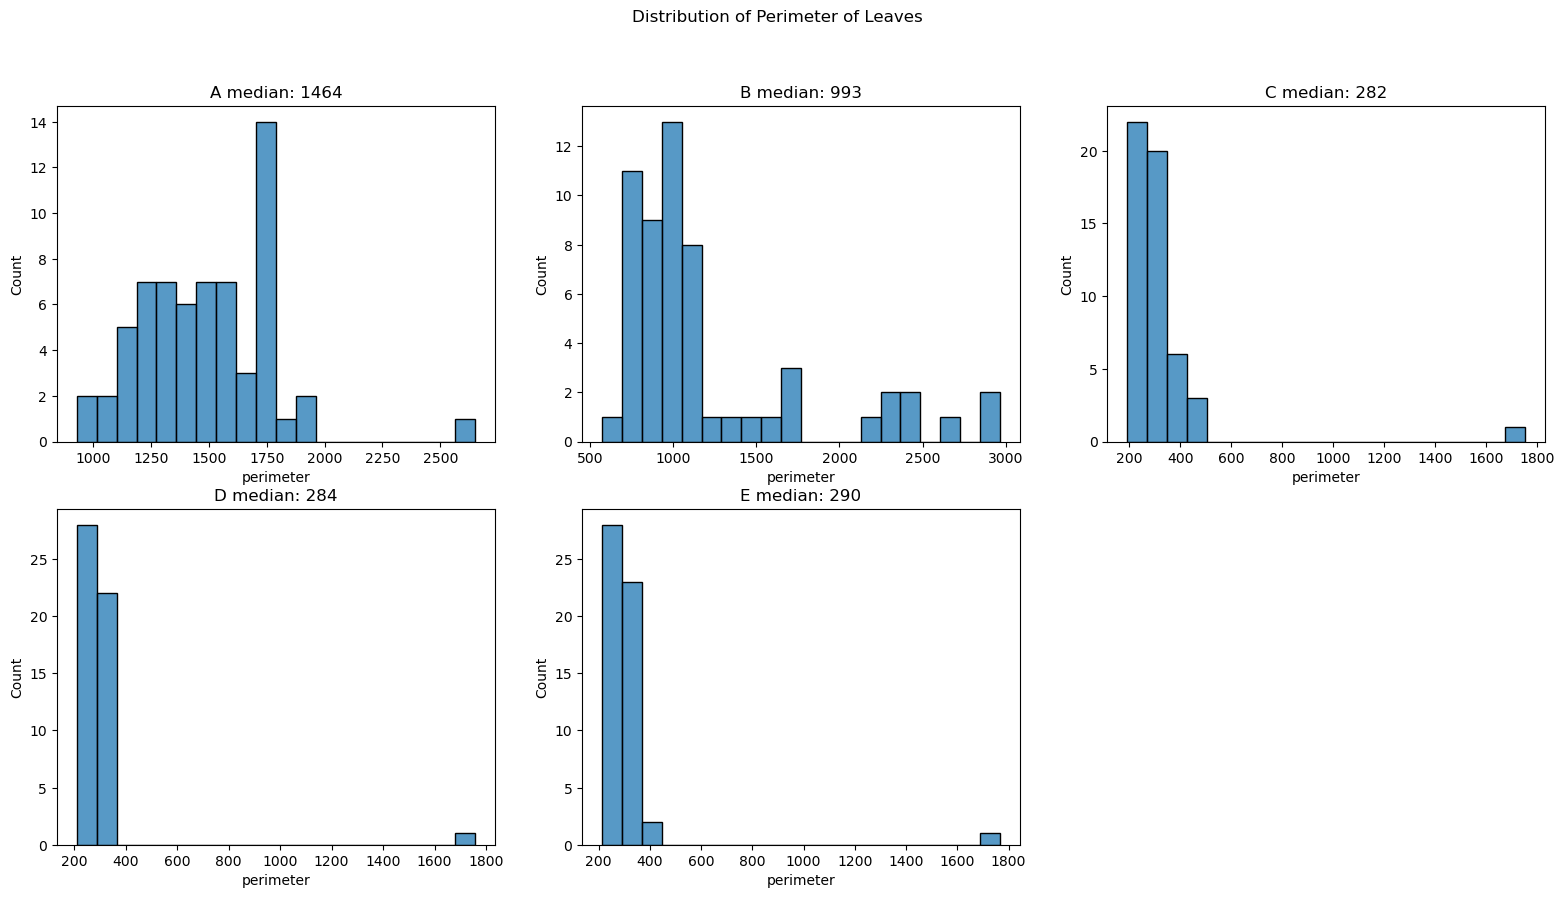

In [17]:
fig, axes = plt.subplots(2, 3, figsize=(6.4*3, 4.8*2))
fig.suptitle('Distribution of Perimeter of Leaves')
fig.delaxes(axes[-1][-1])
for i, (class_, ax) in enumerate(zip(df['class'].unique(), axes.flat)):
    filtered_df = df[df["class"] == class_]
    sns.histplot(data=filtered_df, x='perimeter', bins=20,
                 ax=ax)
    ax.set_title(f'{class_} median: {filtered_df.perimeter.median():.0f}')

We can see that there are outliers from our dataset. In our example, we are going to drop these so they cannot influence our machine learning algorithm later on.

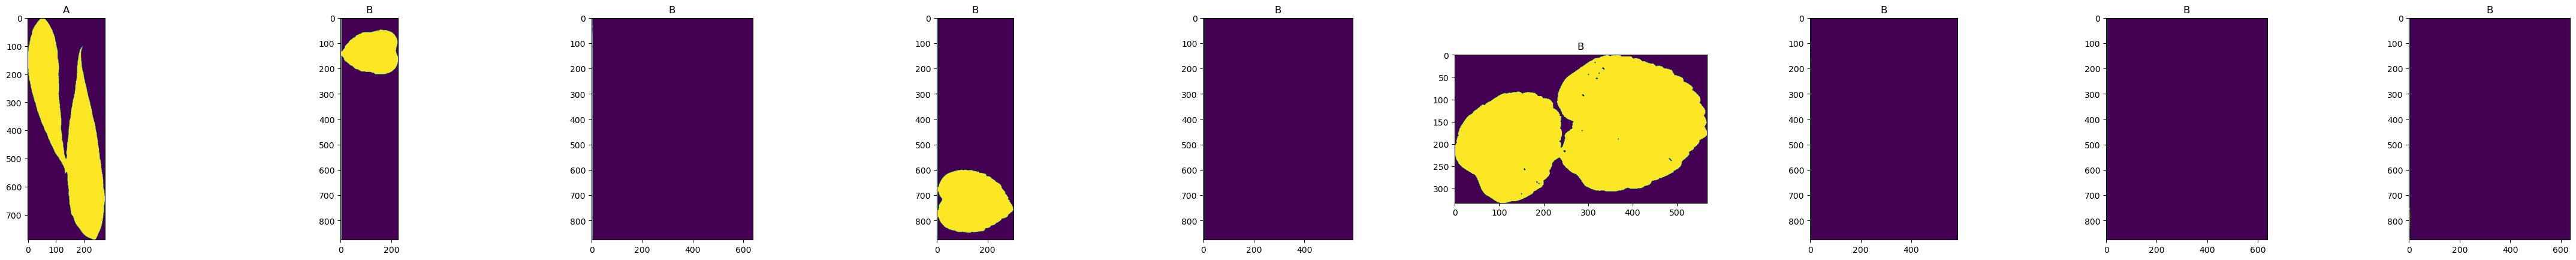

In [18]:
drop_idx = []

class_list = ['A', 'B']

filtered_df = df[(df.perimeter > 2000) & (df['class'].isin(class_list))][
    ['image', 'class']
]

if len(filtered_df) == 1:
    imshow(filtered_df.iloc[0])
else:
    fig, axes = plt.subplots(1, len(filtered_df),
                             figsize=(6.4*len(filtered_df), 4.8))
    for i, ax in enumerate(axes.flat):
        ax.set_title(filtered_df['class'].iloc[i])
        ax.imshow(filtered_df.image.iloc[i])

drop_idx.extend(filtered_df.index.tolist())

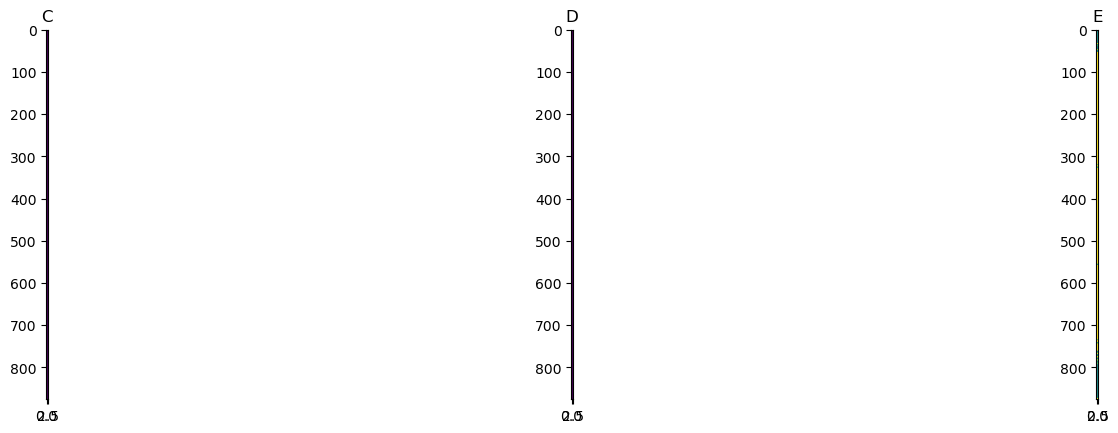

In [19]:
class_list = ['A', 'B']

filtered_df = df[(df.perimeter > 1500) & (~df['class'].isin(class_list))][
    ['image', 'class']
]

if len(filtered_df) == 1:
    imshow(filtered_df.image.iloc[0])
else:
    fig, axes = plt.subplots(1, len(filtered_df),
                             figsize=(6.4*len(filtered_df), 4.8))
    for i, ax in enumerate(axes.flat):
        ax.set_title(filtered_df['class'].iloc[i])
        ax.imshow(filtered_df.image.iloc[i])
        
drop_idx.extend(filtered_df.index.tolist())

In [38]:
print(f'The indices to be dropped are: {drop_idx}')

The indices to be dropped are: [41, 64, 71, 82, 97, 101, 102, 109, 116, 121, 173, 258]


In [21]:
df_cleaned = df.drop(drop_idx).reset_index(drop=True)

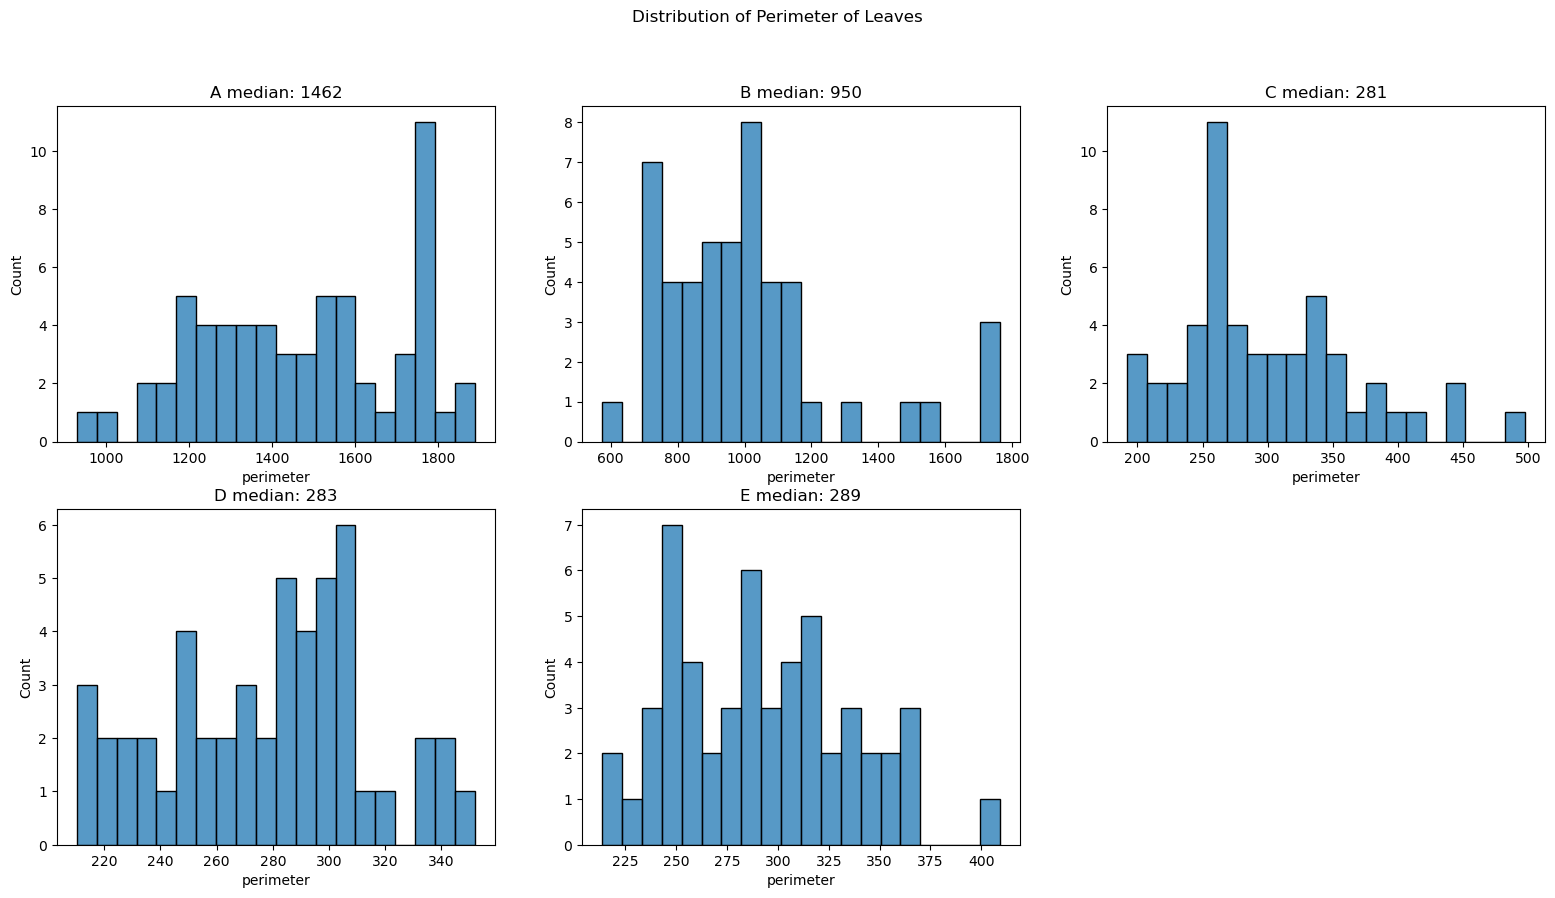

In [22]:
fig, axes = plt.subplots(2, 3, figsize=(6.4*3, 4.8*2))
fig.suptitle('Distribution of Perimeter of Leaves')
fig.delaxes(axes[-1][-1])
for i, (class_, ax) in enumerate(zip(df_cleaned['class'].unique(),
                                     axes.flat)):
    filtered_df = df_cleaned[df_cleaned["class"] == class_]
    sns.histplot(data=filtered_df, x='perimeter', bins=20,
                 ax=ax)
    ax.set_title(f'{class_} median: {filtered_df.perimeter.median():.0f}')

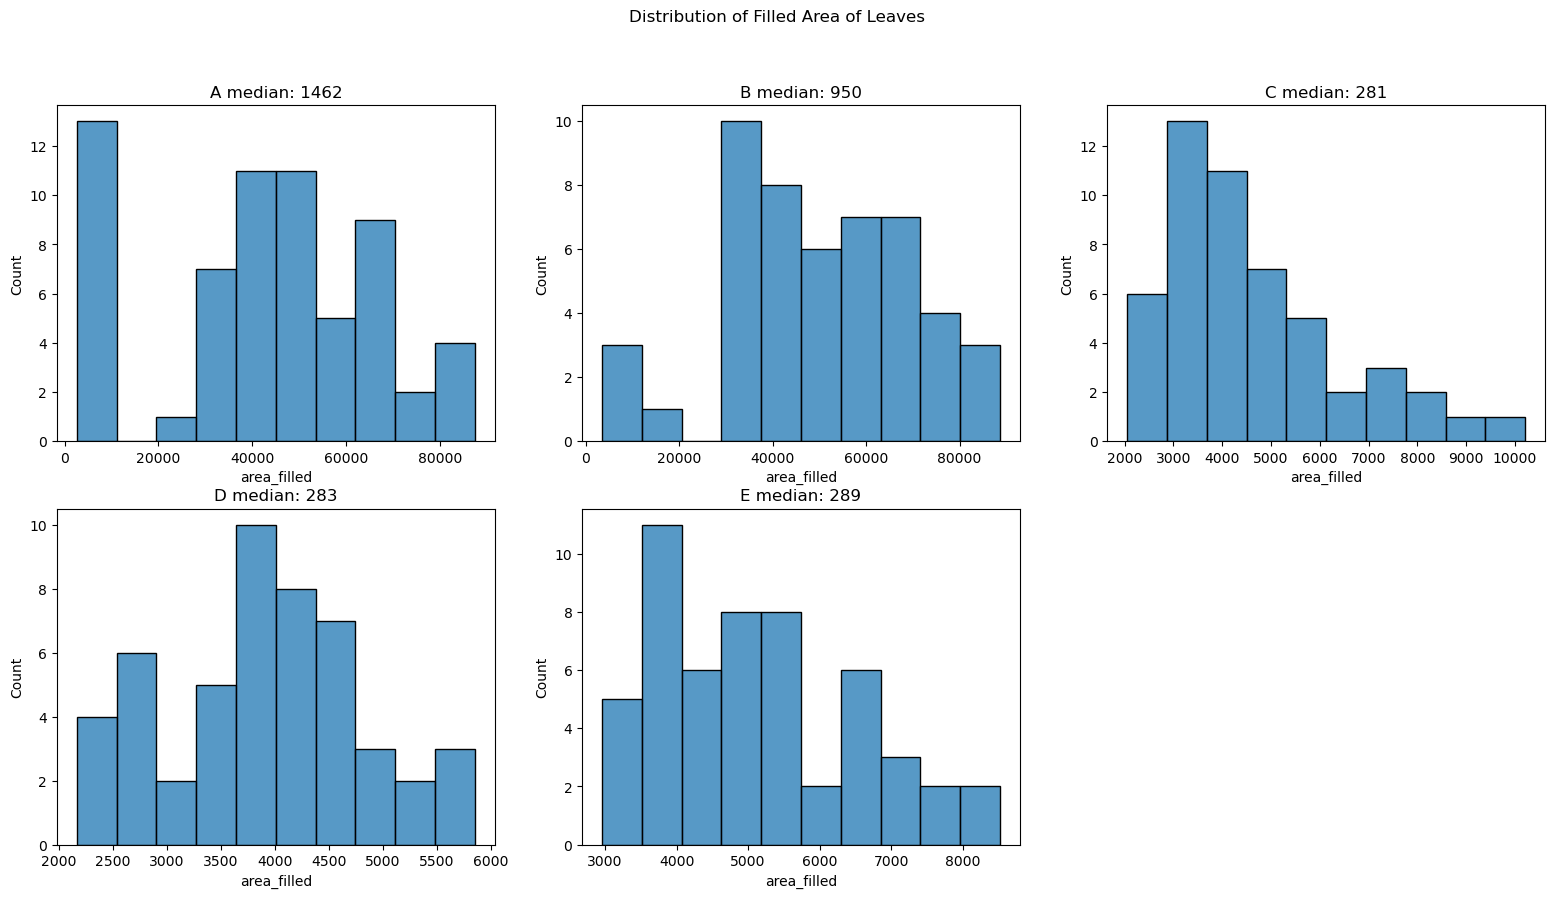

In [23]:
fig, axes = plt.subplots(2, 3, figsize=(6.4*3, 4.8*2))
fig.suptitle('Distribution of Filled Area of Leaves')
fig.delaxes(axes[-1][-1])
for i, (class_, ax) in enumerate(zip(df_cleaned['class'].unique(),
                                     axes.flat)):
    filtered_df = df_cleaned[df_cleaned["class"] == class_]
    sns.histplot(data=filtered_df, x='area_filled', bins=10,
                 ax=ax)
    ax.set_title(f'{class_} median: {filtered_df.perimeter.median():.0f}')

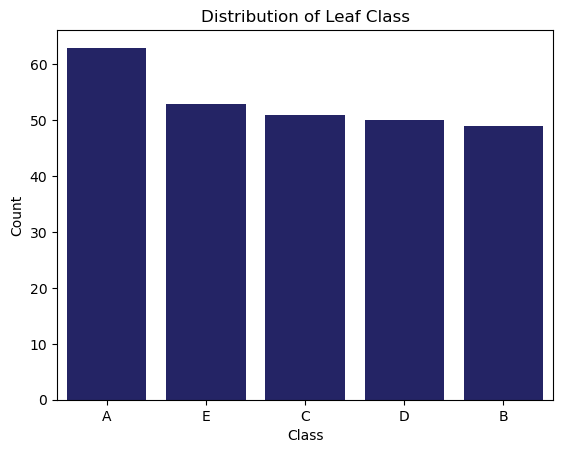

In [24]:
sns.barplot(df_cleaned['class'].value_counts().reset_index(), x='index', y='class',
            color='midnightblue')
plt.title('Distribution of Leaf Class')
plt.xlabel('Class')
plt.ylabel('Count')
plt.show()

Looking at the histogram plots, we can say that we have successfully removed the outliers. We can now move to the bivariate analysis.

#### Bivariate Analysis

Bivariate analysis allows us to uncover patterns, correlations, and dependencies between these variables, providing valuable insights into their interplay and potential impact on our analysis. By studying the connections and associations between these variables, we gain a deeper understanding of the underlying dynamics within our data.

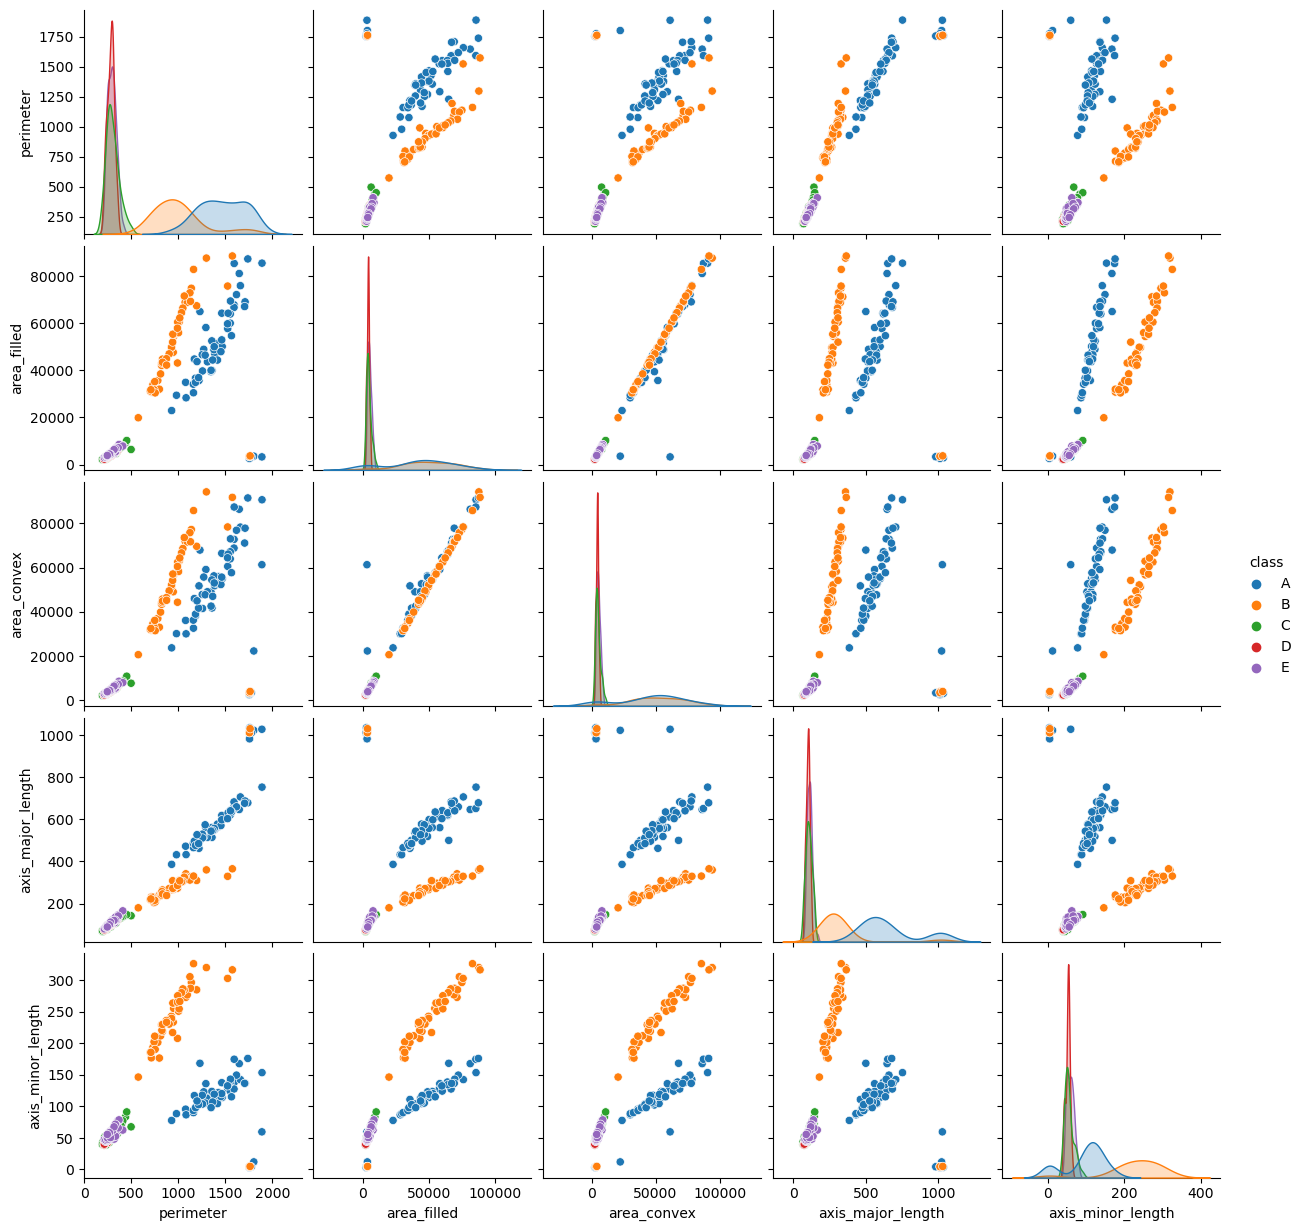

In [28]:
cols = ['perimeter', 'area_filled', 'area_convex', 'axis_major_length',
        'axis_minor_length', 'class']

sns.pairplot(data=df_cleaned[cols], hue='class');

## Machine Learning Pipeline

We now explore the systematic process involved in developing and deploying machine learning models. Through this section, we delve into each stage of the pipeline, providing insights and best practices to guide you through the journey of building effective machine learning models. We first split our data to train, validation and test sets for the cross validation step we will be performing later on.

In [29]:
X = df_cleaned.drop(columns=['class', 'inertia_tensor-1-0',
                             'image']).copy().to_numpy()

y = df_cleaned['class'].to_numpy()

X_trainval, X_test, y_trainval, y_test = train_test_split(
    X, y, test_size=0.25, random_state=143, stratify=y
)

#### Grid Search

To make our prediction robust, we have to perform grid search on different hyperparameters using different models. But before that we have to define a standard scaler for our dataframe to normalize our data.

In [30]:
rng = np.random.RandomState(143)

skfold = StratifiedKFold(n_splits=5, shuffle=True, random_state=rng)

pipeline = Pipeline([('scaler', StandardScaler()),
                     ('classifier', LogisticRegression())])

param_grid = [
    {
        'classifier': [KNeighborsClassifier()],
        'classifier__n_neighbors': [3, 5, 10, 15]
    },
    {
        'classifier': [LogisticRegression(solver='saga', max_iter=10_000)],
        'classifier__penalty': ['l1', 'l2'],
        'classifier__C': [0.1, 1, 10]
    },
    {
        'classifier': [SVC(random_state=rng)],
        'classifier__kernel': ['linear', 'rbf'],
        'classifier__C': [0.1, 1, 10]
    },
    {
        'classifier': [RandomForestClassifier(random_state=rng)],
        'classifier__n_estimators': [100, 150, 200],
        'classifier__max_depth': [3, 5, 7]
    },
    {
        'classifier': [GradientBoostingClassifier(random_state=rng)],
        'classifier__n_estimators': [100, 150, 200],
        'classifier__max_depth': [3, 5, 7]
    }
]

In [31]:
gs = GridSearchCV(pipeline,
                  param_grid=param_grid,
                  cv=skfold,
                  verbose=1)

gs.fit(X_trainval, y_trainval)

gs.best_estimator_

Fitting 5 folds for each of 34 candidates, totalling 170 fits


Pipeline(steps=[('scaler', StandardScaler()),
                ('classifier',
                 GradientBoostingClassifier(random_state=RandomState(MT19937) at 0x7F06BE576C40))])

After performing training, we now get the model with the best score and save it to a pickle to be used for the classification report.

In [32]:
joblib.dump(gs, 'gs.pkl')

['gs.pkl']

Our best model is able to get a test accuracy of 95.52%.

In [39]:
print(classification_report(y_test, gs.predict(X_test)))

print('Test Accuracy: '
      f'{accuracy_score(y_test, gs.predict(X_test)) * 100:.2f}%')

              precision    recall  f1-score   support

           A       1.00      1.00      1.00        16
           B       1.00      0.92      0.96        12
           C       0.86      0.92      0.89        13
           D       0.92      0.92      0.92        13
           E       1.00      1.00      1.00        13

    accuracy                           0.96        67
   macro avg       0.96      0.95      0.95        67
weighted avg       0.96      0.96      0.96        67

Test Accuracy: 95.52%


This shows that utilizing regionprops to get the different attributes of the leaves can yield a good prediction without the use of deep learning models. Now as a bonus, we are going to deploy explainability methods to see which features affect our prediction the most.

## Explainability

SHAP or SHapley Additive exPlanations provides a comprehensive framework for understanding the contribution of individual features to the predictions made by machine learning models. By utilizing SHAP, we gain deeper insights into the significance of each feature and the intricate interactions that shape the model's predictions, ultimately enhancing transparency and trust in our machine learning models.

In [35]:
cols = df_cleaned.columns.drop(['image', 'inertia_tensor-1-0', 'class'])

shap_explainer = shap.Explainer(gs.predict_proba, X_trainval,
                                feature_names=cols)
shap_values = shap_explainer(X_test)

shap_explanation = shap.Explanation(shap_values.values[:, :, 1],
                                    shap_values.base_values[0][1],
                                    shap_values.data,
                                    feature_names=cols)

Exact explainer: 68it [00:28,  1.75it/s]                        


No data for colormapping provided via 'c'. Parameters 'vmin', 'vmax' will be ignored


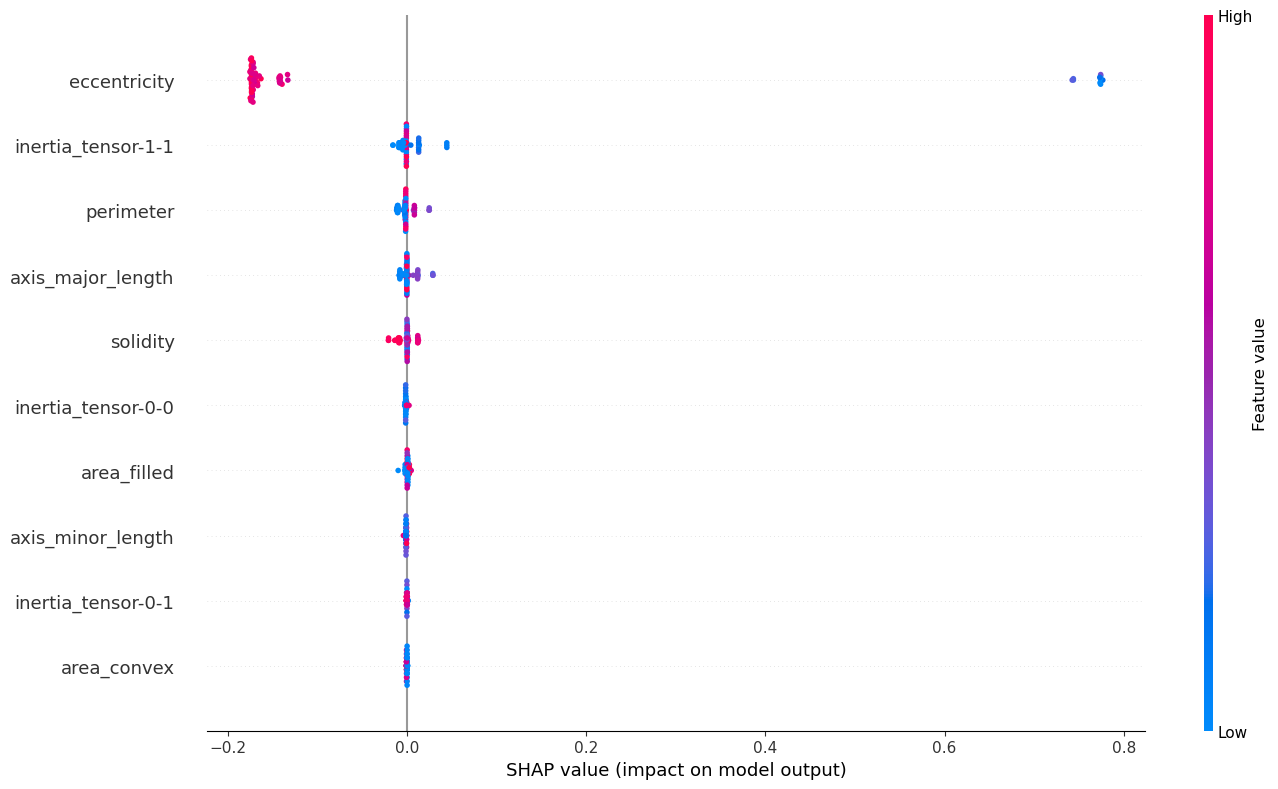

In [36]:
shap.summary_plot(shap_explanation, plot_size=(14, 8))

We can see that the eccentricity of the leaves has the highest negative impact on our model when it is deciding if it belongs to a certain class of leaves.

In our journey, we emphasized the significance of image processing techniques, specifically regionprops, in creating a structured DataFrame. These techniques enabled the extraction of meaningful features from images, facilitating the development of robust machine learning models. We highlighted the importance of data preprocessing and its impact on model performance. By harnessing these image processing methods, you can enhance your machine learning endeavors and gain valuable insights from your data.